In [1]:
import datetime
import os

from serial import Serial
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyubx2 import UBXReader, UBX_PROTOCOL, UBXMessage, SET_LAYER_RAM, POLL_LAYER_RAM, TXN_COMMIT, TXN_NONE

In [2]:
tim_tp_packet_data_dir = 'tim_tp_data'

def save_tim_tp_data(df):
    os.makedirs(tim_tp_packet_data_dir, exist_ok=True)
    now = datetime.datetime.now().isoformat()
    tim_tp_fname = f'start_{now}'
    with open(f'{tim_tp_packet_data_dir}/{tim_tp_fname}', 'w') as f:
        tim_tp_df.to_csv(f)
    return tim_tp_fname


def load_tim_tp_data(fname):
    with open(f'{tim_tp_packet_data_dir}/{fname}', 'r') as f:
        df = pd.read_csv(f, index_col=0)
    return df 

In [3]:
usb_tty_port = '/dev/cu.usbmodem1201'

In [4]:
# Poll configuration of "CFG_MSGOUT_UBX_TIM_TP_USB". On startup, should be 0 by default.
layer = POLL_LAYER_RAM
position = 0
keys = ["CFG_MSGOUT_UBX_TIM_TP_USB"]

msg = UBXMessage.config_poll(layer, position, keys)
print(msg)
with Serial(usb_tty_port, 38400, timeout=3) as stream:
    stream.write(msg.serialize())
    ubr_poll_status = UBXReader(stream, protfilter=UBX_PROTOCOL)
    raw_data, parsed_data = ubr_poll_status.read()
    if parsed_data is not None:
        print(parsed_data)

<UBX(CFG-VALGET, version=0, layer=0, position=0, keys_01=546374016)>
<UBX(CFG-VALGET, version=1, layer=0, position=0, CFG_MSGOUT_UBX_TIM_TP_USB=0)>


In [5]:
# Set configuration of "CFG_MSGOUT_UBX_TIM_TP_USB" to 1.
layer = SET_LAYER_RAM
transaction = TXN_NONE
cfgData = [("CFG_MSGOUT_UBX_TIM_TP_USB", 1)]

msg = UBXMessage.config_set(layer, transaction, cfgData)
print(msg)
with Serial(usb_tty_port, 38400, timeout=100) as stream:
    stream.write(msg.serialize())
    ubr = UBXReader(stream, protfilter=UBX_PROTOCOL)
    for i in range(2):
        raw_data, parsed_data = ubr.read()
        if parsed_data is not None:
            print(parsed_data)

<UBX(CFG-VALSET, version=0, ram=1, bbr=0, flash=0, action=0, reserved0=0, CFG_MSGOUT_UBX_TIM_TP_USB=1)>
<UBX(ACK-ACK, clsID=CFG, msgID=CFG-VALSET)>
<UBX(TIM-TP, towMS=513887000, towSubMS=0.0, qErr=-2251, week=2319, timeBase=0, utc=1, raim=2, qErrInvalid=0, TpNotLocked=0, timeRefGnss=0, utcStandard=0)>


## UBX_TIM_TP_documentation
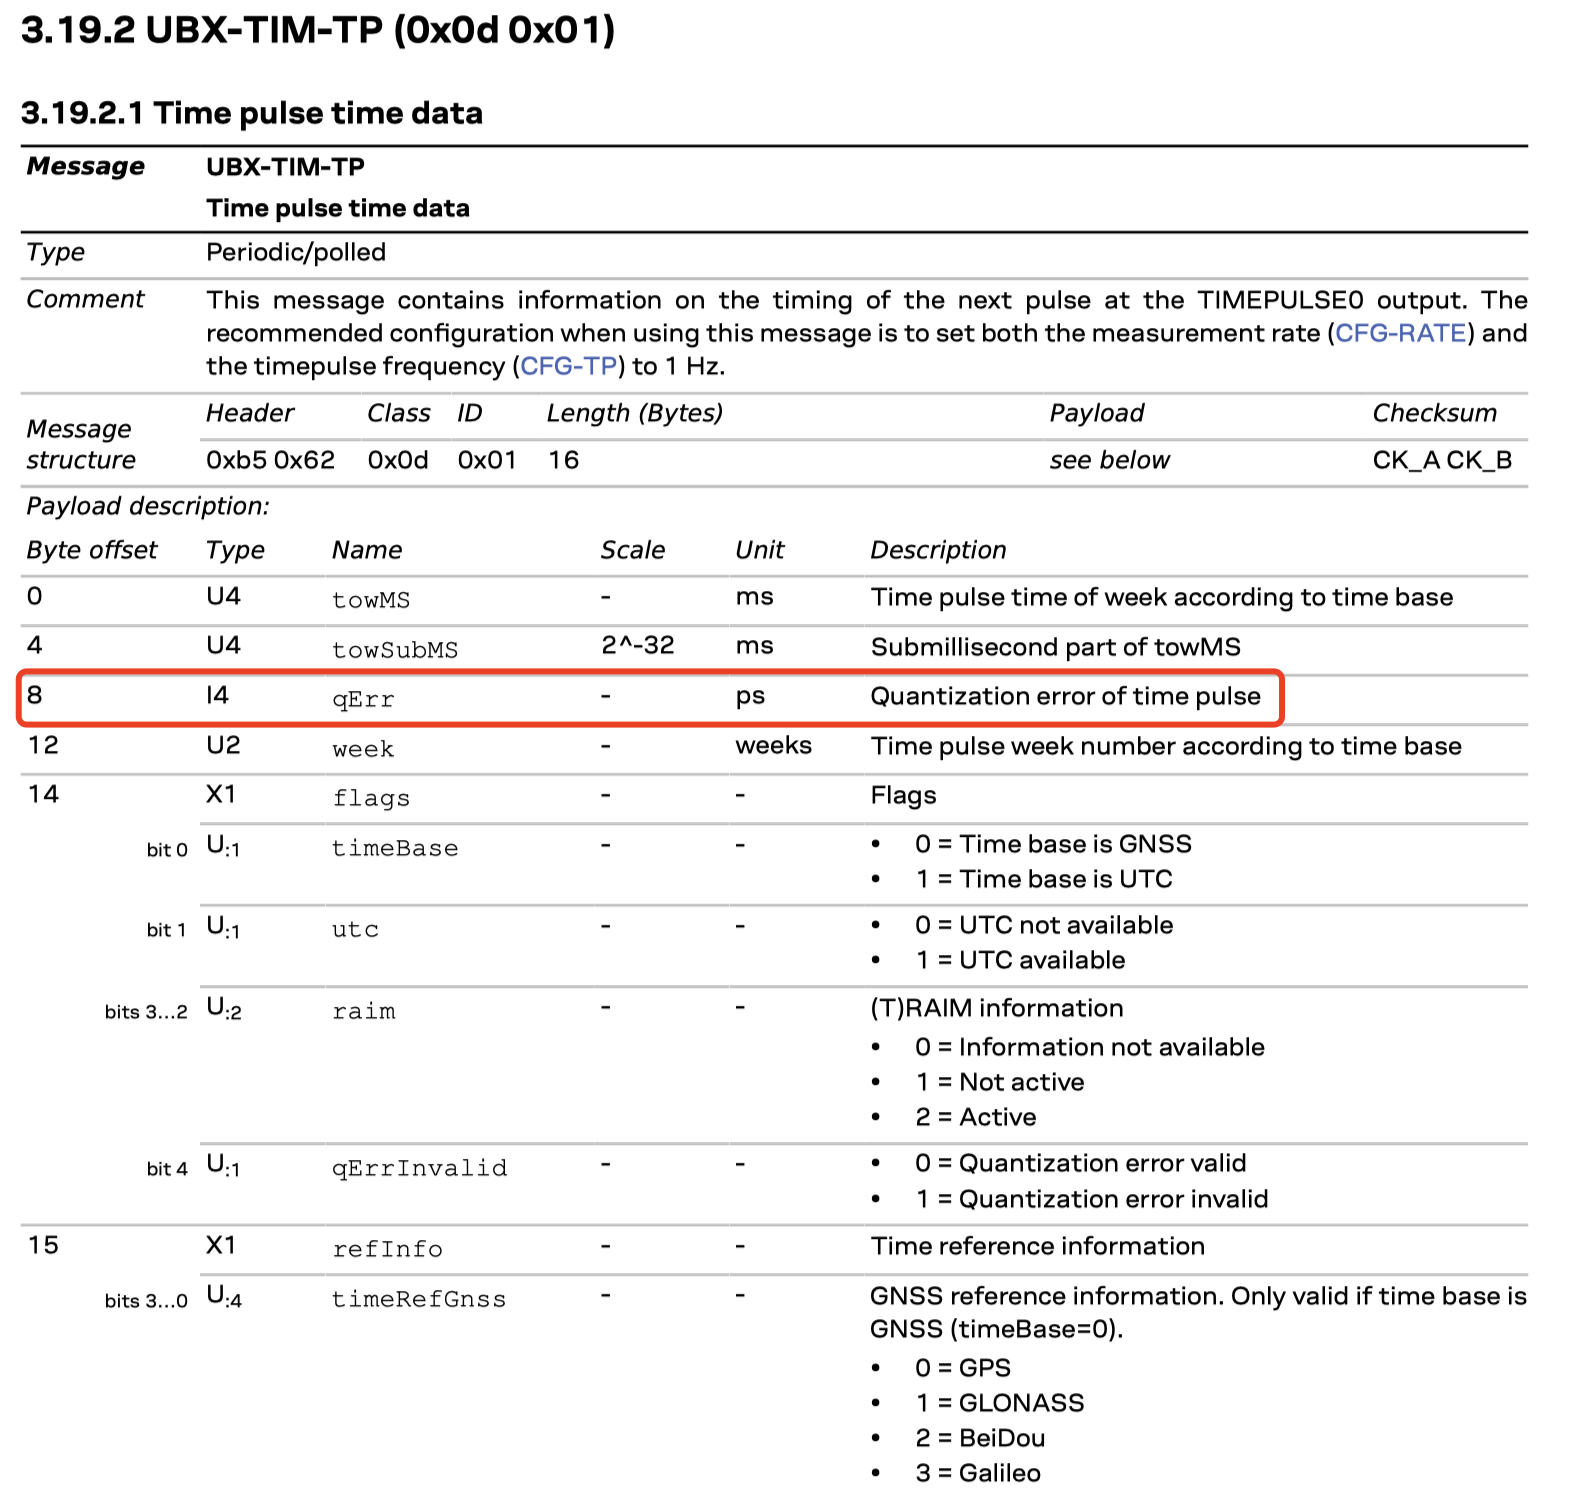

In [6]:
# Read UBX packets from the receiver via the usb_tty_port and write the TIM-TP packets to the pd.DataFrame tim_tp_df
tim_tp_df = pd.DataFrame(
    columns=['towMS (ms)', # Byte offset 4: towMS (unit: ms)
             'towSubMS', # Byte offset 8: towSubMS (unit: ms, scale: 2^-32)
             'qErr (ps)', # Byte offset 8: qErr (unit: ps)
             'week (weeks)', # Byte offset 12: week (unit: weeks)
             # Byte offset 14: flags
             'timeBase_flag',
             'utc_flag',
             'raim_flag',
             'qErrInvalid_flag',
             # Byte offset 15: refInfo
             'timeRefGnss']
)

with Serial(usb_tty_port, 38400, timeout=3) as stream:
    ubr = UBXReader(stream, protfilter=UBX_PROTOCOL)
    try:
        while True:
            raw_data, parsed_data = ubr.read()
            if parsed_data and parsed_data.identity == 'TIM-TP':
                print(parsed_data);
                # See section 3.19.2 UBX-TIM-TP
                data = {
                    'towMS (ms)': parsed_data.towMS, 
                    'towSubMS': parsed_data.towSubMS, 
                    'qErr (ps)': parsed_data.qErr, 
                    'week (weeks)': parsed_data.week, 
                    'timeBase_flag': parsed_data.timeBase,
                    'utc_flag': parsed_data.utc,
                    'raim_flag': parsed_data.raim,
                    'qErrInvalid_flag': parsed_data.qErrInvalid,
                    'timeRefGnss': parsed_data.timeRefGnss,
                }
                tim_tp_df.loc[len(tim_tp_df)] = data
                # print(data)
    except KeyboardInterrupt:
        pass
# d = [attr for attr in dir(parsed_data) if attr[0] != '_']
# remove_attrs = ['TpNotLocked', 'config_del', 'config_poll', 'config_set', 'serialize']
# for attr in remove_attrs:
#     d.remove(attr)
# print(d)
# parsed_data.week
print('\n', tim_tp_df.info(), '\n')
tim_tp_df

<UBX(TIM-TP, towMS=513888000, towSubMS=0.0, qErr=2635, week=2319, timeBase=0, utc=1, raim=2, qErrInvalid=0, TpNotLocked=0, timeRefGnss=0, utcStandard=0)>
<UBX(TIM-TP, towMS=513889000, towSubMS=0.0, qErr=-355, week=2319, timeBase=0, utc=1, raim=2, qErrInvalid=0, TpNotLocked=0, timeRefGnss=0, utcStandard=0)>
<UBX(TIM-TP, towMS=513890000, towSubMS=0.0, qErr=-3828, week=2319, timeBase=0, utc=1, raim=2, qErrInvalid=0, TpNotLocked=0, timeRefGnss=0, utcStandard=0)>
<UBX(TIM-TP, towMS=513891000, towSubMS=0.0, qErr=-816, week=2319, timeBase=0, utc=1, raim=2, qErrInvalid=0, TpNotLocked=0, timeRefGnss=0, utcStandard=0)>
<UBX(TIM-TP, towMS=513892000, towSubMS=0.0, qErr=-74, week=2319, timeBase=0, utc=1, raim=2, qErrInvalid=0, TpNotLocked=0, timeRefGnss=0, utcStandard=0)>
<UBX(TIM-TP, towMS=513893000, towSubMS=0.0, qErr=1282, week=2319, timeBase=0, utc=1, raim=2, qErrInvalid=0, TpNotLocked=0, timeRefGnss=0, utcStandard=0)>
<UBX(TIM-TP, towMS=513894000, towSubMS=0.0, qErr=-2498, week=2319, timeBase=

,towMS (ms),towSubMS,qErr (ps),week (weeks),timeBase_flag,utc_flag,raim_flag,qErrInvalid_flag,timeRefGnss
0,513888000,0.0,2635,2319,0,1,2,0,0
1,513889000,0.0,-355,2319,0,1,2,0,0
2,513890000,0.0,-3828,2319,0,1,2,0,0
3,513891000,0.0,-816,2319,0,1,2,0,0
4,513892000,0.0,-74,2319,0,1,2,0,0
...,...,...,...,...,...,...,...,...,...
193,514081000,0.0,206,2319,0,1,2,0,0
194,514082000,0.0,1684,2319,0,1,2,0,0
195,514083000,0.0,3472,2319,0,1,2,0,0
196,514084000,0.0,-3306,2319,0,1,2,0,0


Text(0, 0.5, 'Q-Errors (ps)')

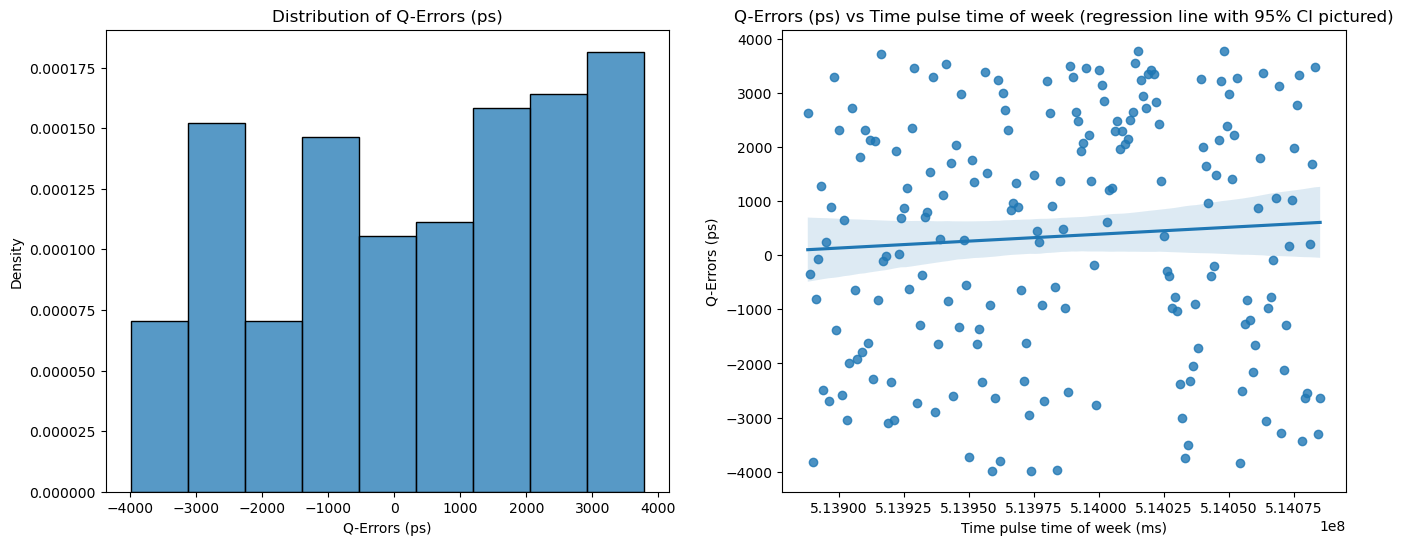

In [9]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
sns.histplot(tim_tp_df, x='qErr (ps)', stat='density', ax=ax1)
ax1.set_title('Distribution of Q-Errors (ps)')
ax1.set_xlabel('Q-Errors (ps)')

plt.subplot(1,2,2)
sns.regplot(tim_tp_df, x='towMS (ms)', y='qErr (ps)', ci=95)
ax2.set_title('Q-Errors (ps) vs Time pulse time of week (regression line with 95% CI pictured)');
ax2.set_xlabel('Time pulse time of week (ms)')
ax2.set_ylabel('Q-Errors (ps)')

In [10]:
# Test data saving and loading code:

fname = save_tim_tp_data(tim_tp_df)
loaded_tim_tp_df = load_tim_tp_data(fname)
all(loaded_tim_tp_df == tim_tp_df)

True